In [1]:
import pymc as pm
import aesara.tensor as at
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
from scipy.stats import hmean
plt.style.use("bmh")
plt.rcParams["figure.constrained_layout.use"] = True


<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


In [2]:
full_schedule = pd.read_csv("schedule.csv")
full_schedule

,Date,Visitor,G,Home,G.1,Unnamed: 5,Att.,LOG,Notes
0,2022-10-07,San Jose Sharks,1.0,Nashville Predators,4.0,NaN,16648.0,2:43,at (Prague CZ)
1,2022-10-08,Nashville Predators,3.0,San Jose Sharks,2.0,NaN,17023.0,2:33,at (Prague CZ)
2,2022-10-11,Vegas Golden Knights,4.0,Los Angeles Kings,3.0,NaN,18230.0,2:31,NaN
3,2022-10-11,Tampa Bay Lightning,1.0,New York Rangers,3.0,NaN,18006.0,2:21,NaN
4,2022-10-12,Seattle Kraken,4.0,Anaheim Ducks,5.0,OT,17530.0,2:28,NaN
...,...,...,...,...,...,...,...,...,...
1305,2023-04-13,Minnesota Wild,NaN,Nashville Predators,NaN,NaN,NaN,NaN,NaN
1306,2023-04-13,Toronto Maple Leafs,NaN,New York Rangers,NaN,NaN,NaN,NaN,NaN
1307,2023-04-13,Vegas Golden Knights,NaN,Seattle Kraken,NaN,NaN,NaN,NaN,NaN
1308,2023-04-13,Detroit Red Wings,NaN,Tampa Bay Lightning,NaN,NaN,NaN,NaN,NaN


In [3]:
full_schedule = pd.read_csv("schedule.csv")
full_schedule = (
    full_schedule
    .dropna(subset=["G"])
    .rename(columns={"G":"away_score", "G.1": "home_score", "Unnamed: 5": "OT"})
    .loc[:, ["Date", "Visitor", "away_score", "Home", "home_score", "OT"]]
    .assign(
        regulation_away_score=lambda df_: np.where(
            df_.OT == "OT",
            np.minimum(df_.away_score, df_.home_score),
            df_.away_score
        ).astype(int),
        regulation_home_score=lambda df_: np.where(
            df_.OT == "OT",
            np.minimum(df_.away_score, df_.home_score),
            df_.home_score
        ).astype(int),
        home_score=lambda df_: df_.home_score.astype(int),
        away_score=lambda df_: df_.away_score.astype(int),
        home_win = lambda df_: (df_.home_score > df_.away_score).astype(bool)
    )
)

In [4]:
df_f = full_schedule
df_f.head()

,Date,Visitor,away_score,Home,home_score,OT,regulation_away_score,regulation_home_score,home_win
0,2022-10-07,San Jose Sharks,1,Nashville Predators,4,NaN,1,4,True
1,2022-10-08,Nashville Predators,3,San Jose Sharks,2,NaN,3,2,False
2,2022-10-11,Vegas Golden Knights,4,Los Angeles Kings,3,NaN,4,3,False
3,2022-10-11,Tampa Bay Lightning,1,New York Rangers,3,NaN,1,3,True
4,2022-10-12,Seattle Kraken,4,Anaheim Ducks,5,OT,4,4,True


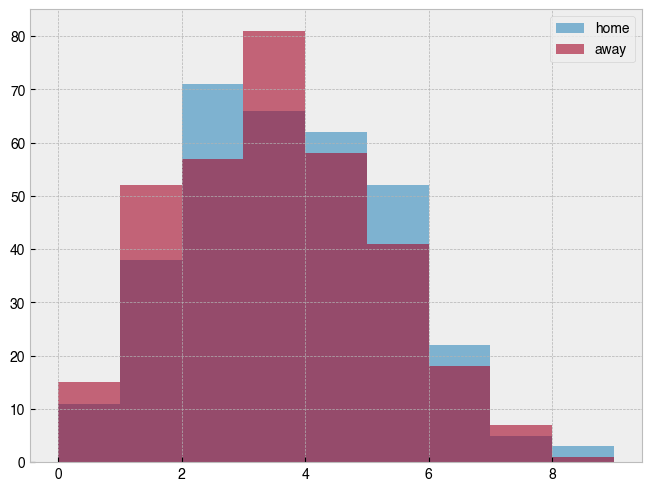

In [5]:
df_f.home_score.hist(bins=np.arange(0,10), alpha=0.6, label="home")
df_f.away_score.hist(bins=np.arange(0,10), alpha=0.6, label="away")
plt.legend()

In [6]:
home_idx, teams = pd.factorize(df_f["Home"], sort=True)
away_idx, _ = pd.factorize(df_f["Visitor"], sort=True)
coords = {"team": teams}

In [7]:
with pm.Model(coords=coords) as model:

    # constant data
    home_team = pm.ConstantData("home_team", home_idx, dims="match")
    away_team = pm.ConstantData("away_team", away_idx, dims="match")

    home_score = pm.MutableData("home_score", df_f.regulation_home_score, dims="match")
    away_score = pm.MutableData("away_score", df_f.regulation_away_score, dims="match")


    # global model parameters
    home = pm.Normal("home", mu=0, sigma=0.2)
    intercept = pm.Normal("intercept", mu=0, sigma=2)

    # attacks
    sd_att = pm.HalfCauchy("sd_att", 0.2)
    atts_star = pm.Normal("atts_star", mu=0, sigma=sd_att, dims="team")

    # defs
    sd_def = pm.HalfCauchy("sd_def", 0.2)
    defs_star = pm.Normal("defs_star", mu=0, sigma=sd_def, dims="team")

    # team-specific model parameters
    atts = pm.Deterministic("atts", atts_star - at.mean(atts_star), dims="team")
    defs = pm.Deterministic("defs", defs_star - at.mean(defs_star), dims="team")
    home_theta = at.exp(intercept + home + atts[home_idx] - defs[away_idx])
    away_theta = at.exp(intercept + atts[away_idx] - defs[home_idx])

    # likelihood of observed data
    home_points = pm.Poisson(
        "home_points",
        mu=home_theta,
        observed=home_score,
        dims=("match"),
    )
    away_points = pm.Poisson(
        "away_points",
        mu=away_theta,
        observed=away_score,
        dims=("match"),
    )

    trace = pm.sample(500, tune=500, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [home, intercept, sd_att, atts_star, sd_def, defs_star]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 179 seconds.


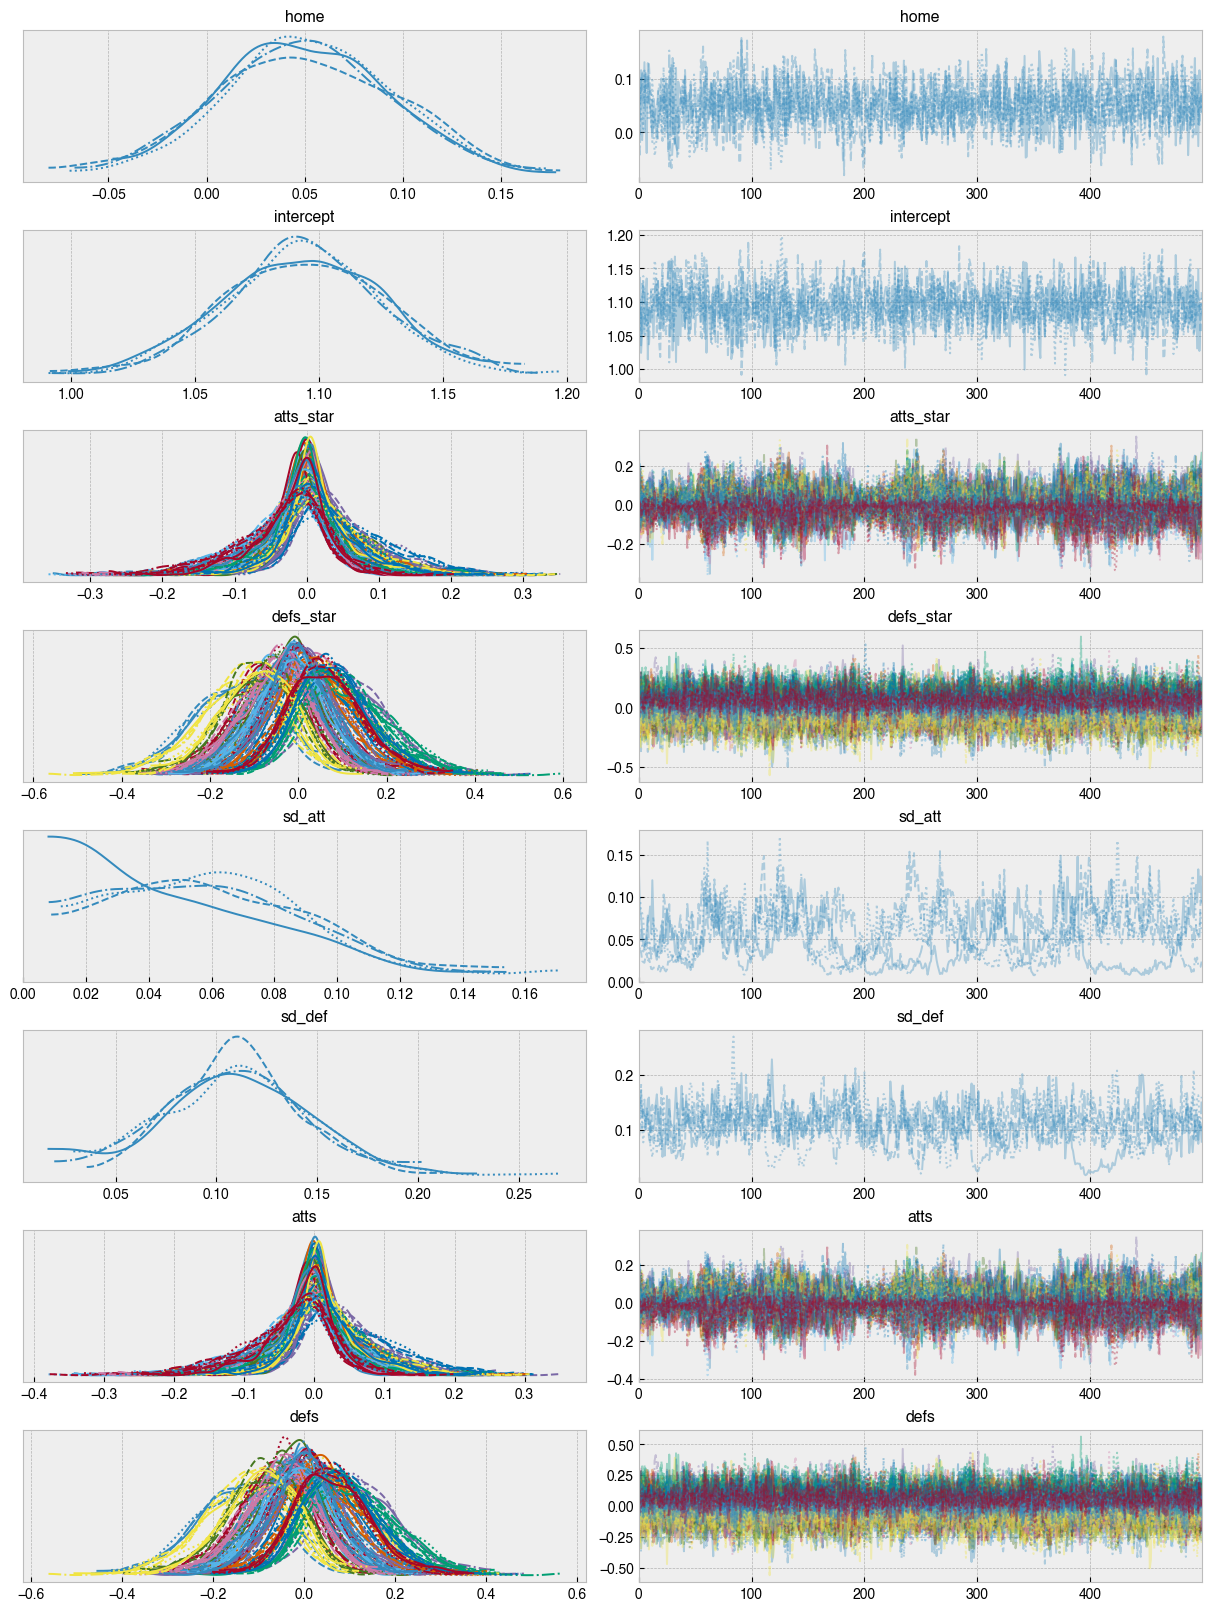

In [8]:
az.plot_trace(trace, compact=True);

In [9]:
name_map = {
"AFM" : "Atlanta Flames",
"ANA" : "Anaheim Ducks",
"ARI" : "Arizona Coyotes",
"ATL" : "Atlanta Thrashers",
"BOS" : "Boston Bruins",
"BRK" : "Brooklyn Americans",
"BUF" : "Buffalo Sabres",
"CAR" : "Carolina Hurricanes",
"CBJ" : "Columbus Blue Jackets",
"CGY" : "Calgary Flames",
"CHI" : "Chicago Blackhawks",
"CLE" : "Cleveland Barons",
"CLR" : "Colorado Rockies",
"COL" : "Colorado Avalanche",
"DAL" : "Dallas Stars",
"DCG" : "Detroit Cougars",
"DET" : "Detroit Red Wings",
"DFL" : "Detroit Falcons",
"EDM" : "Edmonton Oilers",
"FLA" : "Florida Panthers",
"HAM" : "Hamilton Tigers",
"HFD" : "Hartford Whalers",
"KCS" : "Kansas City Scouts",
"LAK" : "Los Angeles Kings",
"MIN" : "Minnesota Wild",
"MMR" : "Montreal Maroons",
"MNS" : "Minnesota North Stars",
"MTL" : "Montreal Canadiens",
"MWN" : "Montreal Wanderers",
"NJD" : "New Jersey Devils",
"NSH" : "Nashville Predators",
"NYA" : "New York Americans",
"NYI" : "New York Islanders",
"NYR" : "New York Rangers",
"OTT" : "Ottawa Senators",
"PHI" : "Philadelphia Flyers",
"PHX" : "Phoenix Coyotes",
"PIR" : "Pittsburgh Pirates",
"PIT" : "Pittsburgh Penguins",
"QBD" : "Quebec Bulldogs",
"QUA" : "Philadelphia Quakers",
"QUE" : "Quebec Nordiques",
"SEA" : "Seattle Kraken",
"SLE" : "St. Louis Eagles",
"SJS" : "San Jose Sharks",
"STL" : "St. Louis Blues",
"TBL" : "Tampa Bay Lightning",
"TOR" : "Toronto Maple Leafs",
"TSP" : "Toronto St. Patricks",
"VAN" : "Vancouver Canucks",
"VGK" : "Vegas Golden Knights",
"WPG" : "Winnipeg Jets",
"WSH" : "Washington Capitals",
}
abbrev_map = {v:k for k, v in name_map.items()}

In [10]:
med_atts = trace.posterior["atts"].median(dim=("chain", "draw"))
med_defs = trace.posterior["defs"].median(dim=("chain", "draw"))

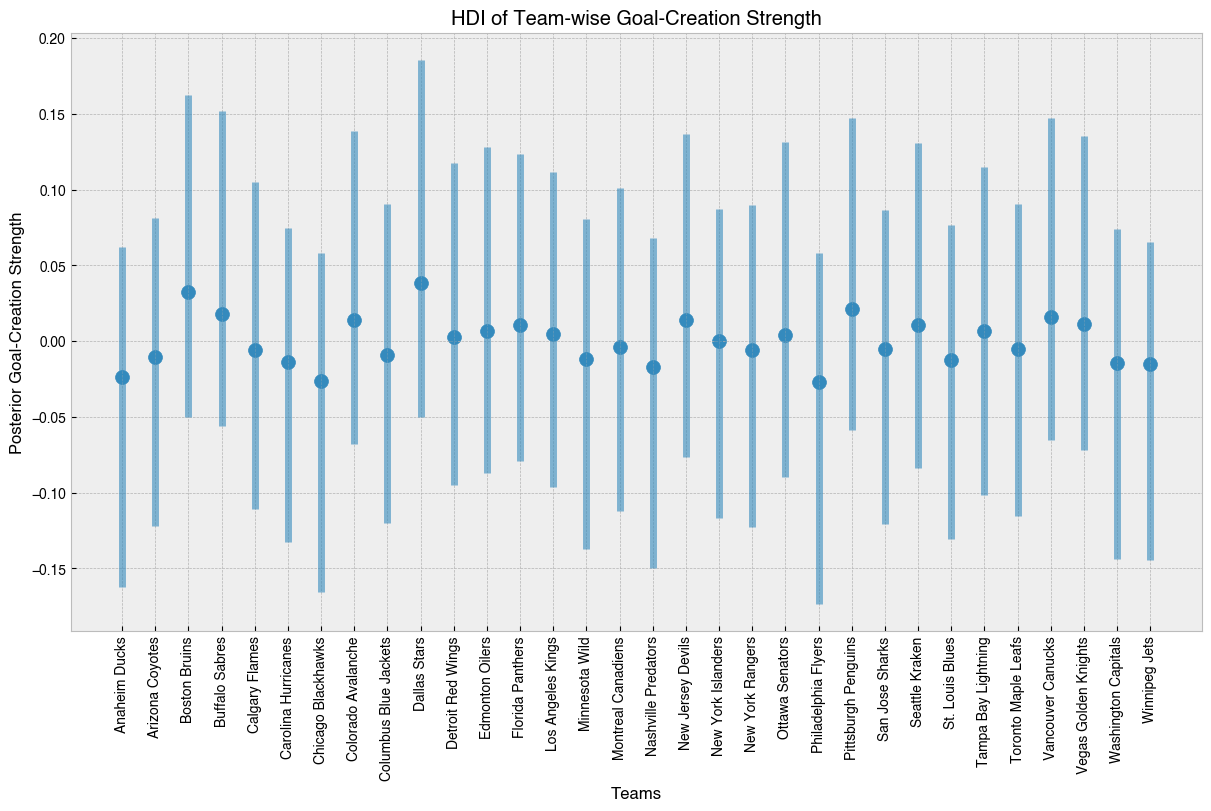

In [11]:
trace_hdi = az.hdi(trace)
_, ax = plt.subplots(figsize=(12, 8))

ax.scatter(teams, med_atts, color="C0", alpha=1, s=100)
ax.vlines(
    teams,
    trace_hdi["atts"].sel({"hdi": "lower"}),
    trace_hdi["atts"].sel({"hdi": "higher"}),
    alpha=0.6,
    lw=5,
    color="C0",
)
ax.set_xlabel("Teams")
ax.set_ylabel("Posterior Goal-Creation Strength")
ax.set_title("HDI of Team-wise Goal-Creation Strength")
plt.xticks(rotation=90);

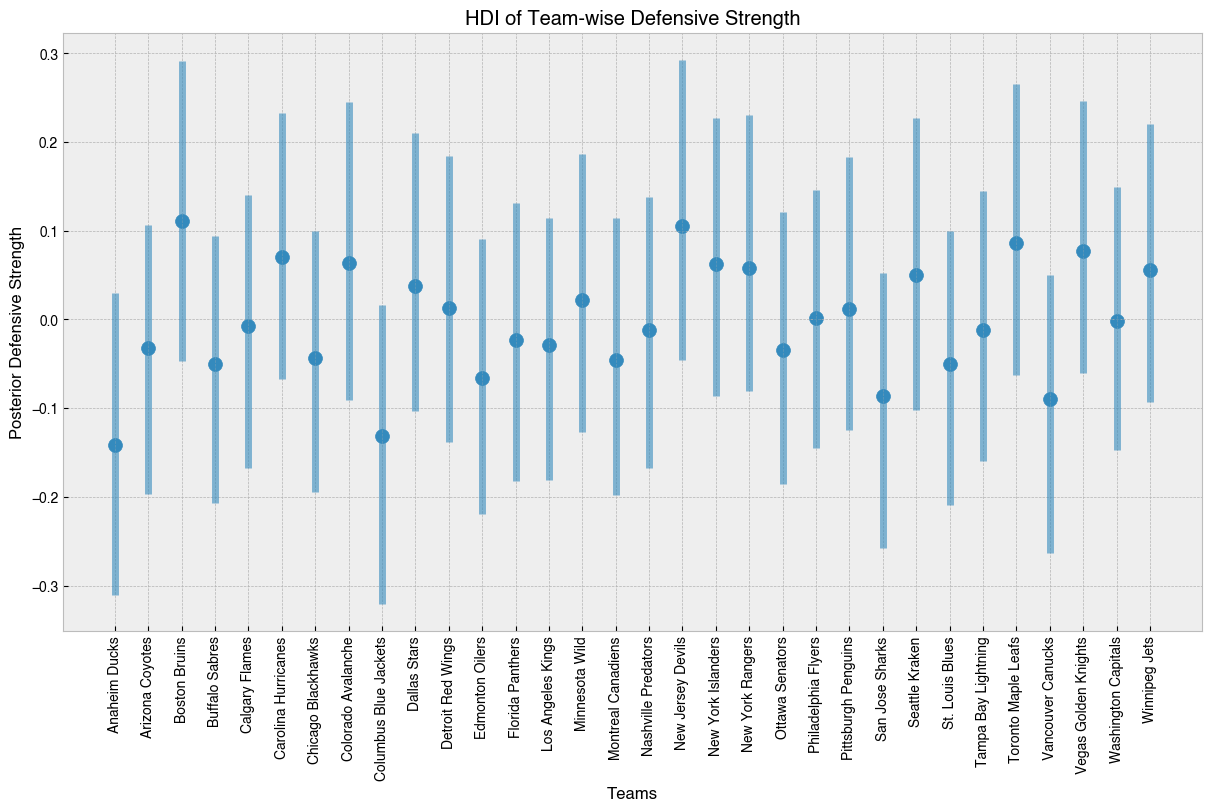

In [12]:
_, ax = plt.subplots(figsize=(12, 8))

ax.scatter(teams, med_defs, color="C0", alpha=1, s=100)
ax.vlines(
    teams,
    trace_hdi["defs"].sel({"hdi": "lower"}),
    trace_hdi["defs"].sel({"hdi": "higher"}),
    alpha=0.6,
    lw=5,
    color="C0",
)
ax.set_xlabel("Teams")
ax.set_ylabel("Posterior Defensive Strength")
ax.set_title("HDI of Team-wise Defensive Strength")
plt.xticks(rotation=90);

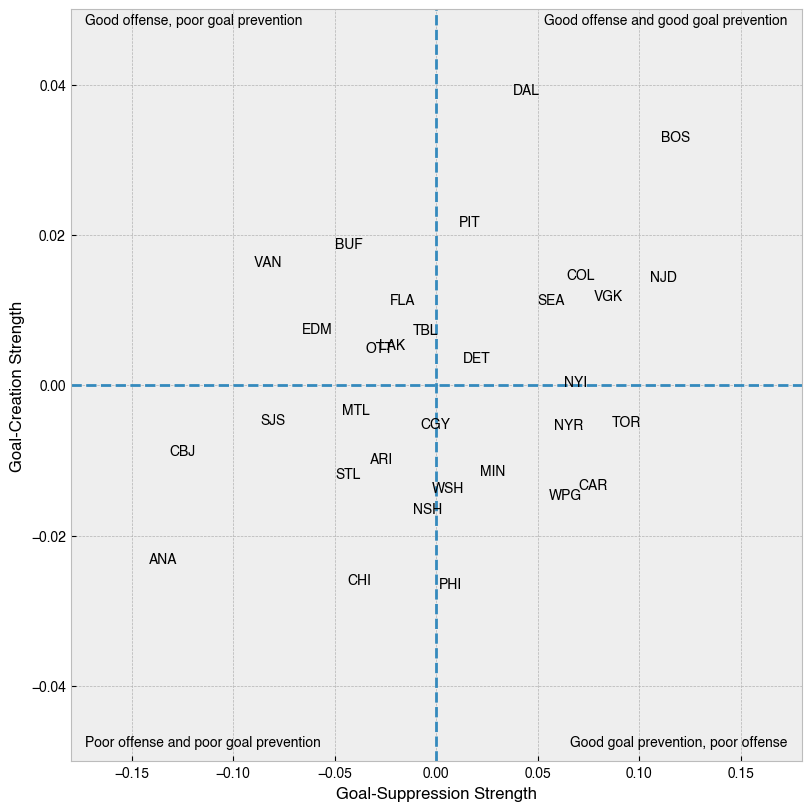

In [13]:
_, ax = plt.subplots(figsize=(8, 8))
plt.xlim(-0.18, 0.18)
plt.ylim(-0.05,0.05)
plt.annotate(text="Good goal prevention, poor offense", xy=(0.98, 0.02), xycoords="axes fraction", ha="right")
plt.annotate(text="Good offense, poor goal prevention", xy=(0.02, 0.98), xycoords="axes fraction", ha="left")
plt.annotate(text="Good offense and good goal prevention", xy=(0.98, 0.98), xycoords="axes fraction", ha="right")
plt.annotate(text="Poor offense and poor goal prevention", xy=(0.02, 0.02), xycoords="axes fraction", ha="left")

for t, a, d in zip(teams, med_atts, med_defs):
    
    plt.annotate(text=abbrev_map[t], xy=(d,a))

plt.xlabel("Goal-Suppression Strength")
plt.ylabel("Goal-Creation Strength")
plt.axvline(0, linestyle="--")
plt.axhline(0, linestyle="--")



In [14]:
with model:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)
sims = (
    az.extract(trace, group="posterior_predictive", combined=True)
    .assign({
        "Home": (("match"), df_f.Home),
        "Visitor": (("match"), df_f.Visitor)
        })
)
post = az.extract(trace, group="posterior", combined=True)


Sampling: [away_points, home_points]


In [15]:
# Get each team win percent by sample for games with decisions
home_win_pct_team = {}
away_win_pct_team = {}
for t in teams:
    home_matches = sims.Home == t
    away_matches = sims.Visitor == t 

    home_wins = (sims.home_points > sims.away_points)[home_matches, :].sum(axis=0)
    home_loss = (sims.home_points < sims.away_points)[home_matches, :].sum(axis=0)
    home_win_pct_team[t] = (home_wins / (home_wins + home_loss)).values

    away_wins = (sims.home_points < sims.away_points)[away_matches, :].sum(axis=0)
    away_loss = (sims.home_points > sims.away_points)[away_matches, :].sum(axis=0)
    away_win_pct_team[t] = (away_wins / (away_wins + away_loss)).values

sims = sims.assign({
    "home_win_pcts":(("match", "sample"), np.stack(df_f.Home.map(home_win_pct_team).values)),
    "away_win_pcts":(("match", "sample"), np.stack(df_f.Visitor.map(away_win_pct_team).values)),
})

# Derive game-wise probability of winning a tie
ties = sims.where(sims.home_points == sims.away_points)
p_home = ties.home_win_pcts
p_away = (1-ties.away_win_pcts)
p_mean = hmean([p_home, p_away])
binomial = np.random.binomial(n=1, p=np.nan_to_num(p_mean, 0))

# Assign tie winners based on updated probability
ties = sims.where(sims.home_points == sims.away_points)
sims = sims.assign({
    "home_wins_tie": (("match", "sample"), ((sims.home_points == sims.away_points) * binomial).data),
    "tie" : (("match", "sample"), (sims.home_points == sims.away_points).data)
})
sims = sims.assign({
    "home_wins_tie": (("match", "sample"), ((sims.home_points == sims.away_points) * binomial).data),
    "tie" : (("match", "sample"), (sims.home_points == sims.away_points).data)
})

# Get updated wins with ties included
sims = sims.assign({"home_wins": (("match","sample"), ((sims.home_points > sims.away_points) | (sims.tie & sims.home_wins_tie)).data)})
sims = sims.assign({"away_wins": (("match","sample"),  (np.logical_not(sims.home_wins).data))})

In [16]:
# Validate
def get_team_season(sims, t):
    hwt = sims.where(sims.Home == t).home_wins.sum(axis=0)
    awt = sims.where(sims.Visitor == t).away_wins.sum(axis=0)
    hlt = np.logical_not(sims.where(sims.Home == t).home_wins).sum(axis=0)
    alt = np.logical_not(sims.where(sims.Visitor == t).away_wins).sum(axis=0)
    total_games = (hwt + awt + hlt + alt).astype(int)
    total_wins = (hwt + awt).astype(int)
    return total_wins, total_games

t = "Boston Bruins"
total_wins, total_games = get_team_season(sims, "Boston Bruins")
assert total_games.std().data == 0
print("Consistent seasons")

Consistent seasons


In [17]:
def get_true_record(df_f, t):
    h = df_f.query(f"Home == '{t}'")
    hw = h.home_win.sum()
    hl = np.logical_not(h.home_win).sum()
    a = df_f.query(f"Visitor == '{t}'")
    al = a.home_win.sum()
    aw = np.logical_not(a.home_win).sum()
    wins = hw + aw
    total = hw + aw + hl + al
    return wins, total

true_wins, true_total = get_true_record(df_f, t)
print(true_wins, true_total)

18 21


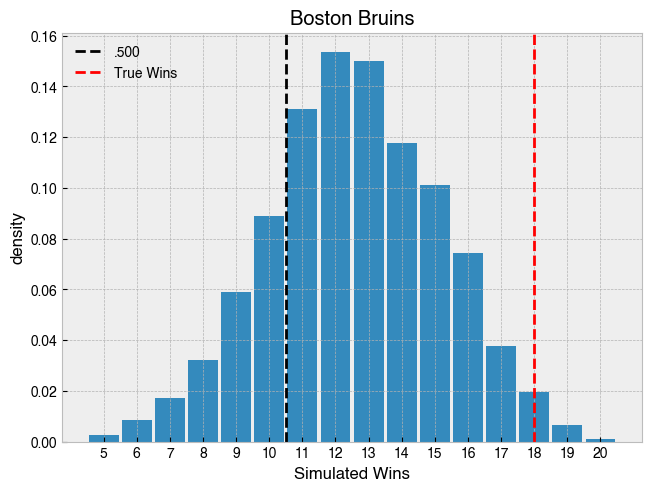

In [43]:
az.plot_dist(total_wins, kind="hist")
plt.axvline(total_games.median() / 2, label=".500", color="black", linestyle="--")
plt.axvline(true_wins, label="True Wins", color="red", linestyle="--")

plt.xlabel("Simulated Wins")
plt.ylabel("density")
plt.title("Boston Bruins")
plt.legend(loc="upper left", frameon=False);

In [46]:
100 * (total_wins >= 18).sum() / len(total_wins)

<xarray.DataArray ()>
array(2.7)

In [41]:
pdf_df = pd.DataFrame()
pdf_df["pdf"] = 100 * pd.Series(total_wins).value_counts().sort_index() / len(total_wins)
pdf_df["cdf"] = pdf_df.cumsum()
pdf_df

,pdf,cdf
5,0.25,0.25
6,0.85,1.10
7,1.70,2.80
8,3.20,6.00
9,5.90,11.90
10,8.90,20.80
11,13.10,33.90
12,15.35,49.25
13,15.00,64.25
14,11.75,76.00


In [36]:
len(total_wins)

2000

In [19]:
xW, simmed_games = {}, {}
tW, true_games = {}, {}
for t in teams:
    xW[t], simmed_games[t] = get_team_season(sims, t)
    tW[t], true_games[t] = get_true_record(df_f, t)
    

In [20]:
for t in teams:
    assert simmed_games[t].std() == 0
    assert simmed_games[t].median() == true_games[t]
print("Success")


Success


In [64]:
xW_median = []
xW_low = []
xW_hi = []
tW_list = []
for t in teams:
    xW_median.append(int(xW[t].median().data))
    hdi_w = az.hdi(xW[t], input_core_dims = [["sample"]], hdi_prob=.68)
    xW_low.append(float(hdi_w.sel({"hdi": "lower"}).x))
    xW_hi.append(float(hdi_w.sel({"hdi": "higher"}).x))

    tW_list.append (tW[t])

low_err = []
hi_err = []
for med, low, hi in zip(xW_median, xW_low, xW_hi):
    low_err.append(med - low)
    hi_err.append(hi - med)

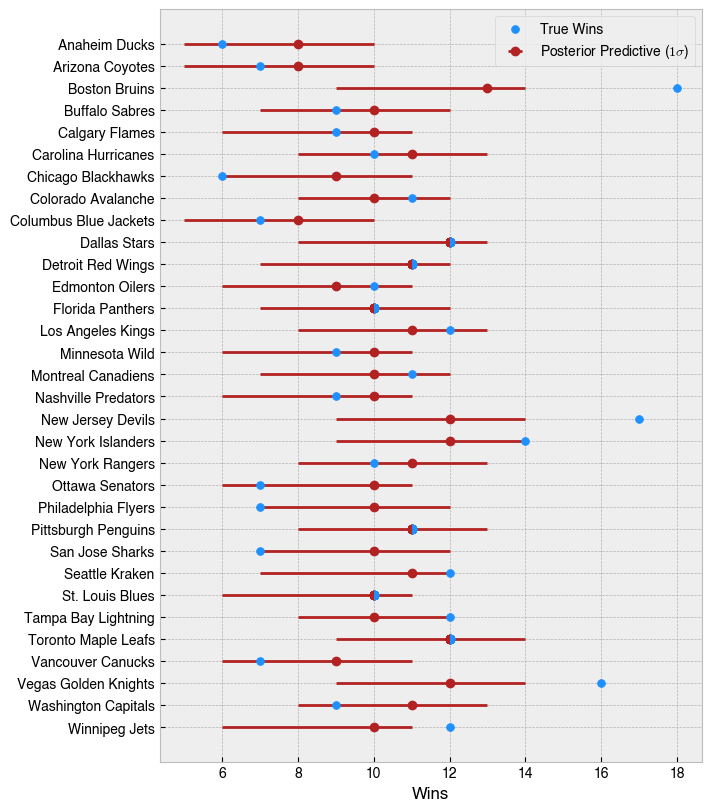

In [65]:
plt.figure(figsize=(7, 8))
plt.errorbar(
    xW_median, np.arange(len(teams),0, -1), 
    xerr=[low_err, hi_err],
    fmt="o",
    color="firebrick",
    label="Posterior Predictive (68% HDI)"
)
plt.scatter(
    tW_list, np.arange(len(teams),0, -1), color="dodgerblue",
    s=32, label="True Wins", zorder=4
)

# Correct for overlap
for t in teams:
    equal = np.array(xW_median) == np.array(tW_list)    
    ex = np.array(xW_median)[equal]
    et = np.array(tW_list)[equal]
    loc = np.arange(len(teams),0, -1)[equal]

    plt.scatter(ex, loc,  marker=MarkerStyle(".", fillstyle="left"), s=150, color="firebrick", zorder=5)
    plt.scatter(et, loc,  marker=MarkerStyle(".", fillstyle="right"), s=150, color="dodgerblue", zorder=6)

plt.yticks(np.arange(len(teams),0, -1), teams)
plt.legend()
plt.xlabel("Wins");


## Non-Hierarchical

Check to make sure that the hierarchical model is better

In [23]:
with pm.Model(coords=coords) as non_hierarchical_model:

    # constant data
    home_team = pm.ConstantData("home_team", home_idx, dims="match")
    away_team = pm.ConstantData("away_team", away_idx, dims="match")

    home_score = pm.MutableData("home_score", df_f.home_score, dims="match")
    away_score = pm.MutableData("away_score", df_f.away_score, dims="match")

    # global model parameters
    home = pm.Normal("home", mu=0, sigma=0.2)
    intercept = pm.Normal("intercept", mu=3, sigma=1)

    # attacks
    atts_star = pm.Normal("atts_star", mu=0.1, sigma=0.3, dims="team")

    # defs
    defs_star = pm.Normal("defs_star", mu=0.1, sigma=0.3, dims="team")

    # team-specific model parameters
    atts = pm.Deterministic("atts", atts_star - at.mean(atts_star), dims="team")
    defs = pm.Deterministic("defs", defs_star - at.mean(defs_star), dims="team")
    home_theta = at.exp(intercept + home + atts[home_idx] - defs[away_idx])
    away_theta = at.exp(intercept + atts[away_idx] - defs[home_idx])

    # likelihood of observed data
    home_points = pm.Poisson(
        "home_points",
        mu=home_theta,
        observed=home_score,
        dims=("match"),
    )
    away_points = pm.Poisson(
        "away_points",
        mu=away_theta,
        observed=away_score,
        dims=("match"),
    )
    non_hier_trace = pm.sample(500, tune=500, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [home, intercept, atts_star, defs_star]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 48 seconds.


In [24]:
with non_hierarchical_model:
    pm.sample_posterior_predictive(non_hier_trace, extend_inferencedata=True)


Sampling: [away_points, home_points]


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
hierarchical,0,-634.889576,9.621690,0.000000,1.000000e+00,9.741536,0.000000,False,log
non-hierarchical,1,-645.251839,22.628385,10.362264,2.131628e-14,9.793724,3.972256,False,log


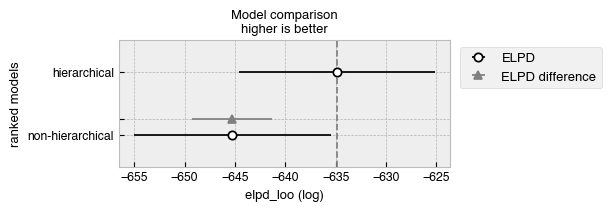

In [25]:
compare_home_points = az.compare({
    "hierarchical": trace,
    "non-hierarchical": non_hier_trace,
}, var_name="home_points")

az.plot_compare(compare_home_points)
compare_home_points

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
hierarchical,0,-626.966831,9.307508,0.000000,1.0,10.003740,0.000000,False,log
non-hierarchical,1,-633.503889,21.536533,6.537058,0.0,10.180878,3.362912,False,log


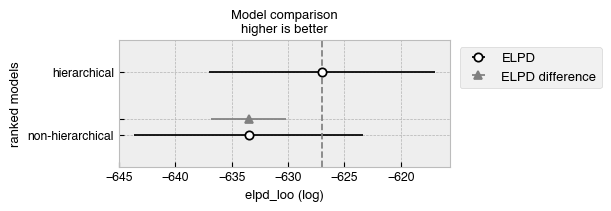

In [26]:
compare_away_points = az.compare({
    "hierarchical": trace,
    "non-hierarchical": non_hier_trace,
}, var_name="away_points")

az.plot_compare(compare_away_points)
compare_away_points

In [27]:
def stdz(v):
    return (v - v.mean()) / v

non_hier_med_atts = non_hier_trace.posterior["atts"].median(dim=("chain", "draw"))
non_hier_med_atts = stdz(non_hier_med_atts)

non_hier_med_defs = non_hier_trace.posterior["defs"].median(dim=("chain", "draw"))
non_hier_med_defs = stdz(non_hier_med_defs)

hier_med_atts =  stdz(med_atts)
hier_med_defs =  stdz(med_defs)
